### Imports

In [26]:
# %load_ext autoreload
# %autoreload 2
import sys
import os
import mne
import torch
import pywt
import joblib
from collections import OrderedDict
from scipy.signal import resample
from numpy.random.mtrand import RandomState
from scipy import linalg
from scipy import signal
from mne import read_evokeds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


sys.path.append('/home/boehms/eeg-gan/EEG-GAN/EEG-GAN')

from eeggan.examples.high_gamma.make_data import load_dataset, load_deeps4, make_deep4_for_subj, make_dataset_for_subj
from eeggan.validation.deep4 import train_completetrials
from eeggan.examples.high_gamma.high_gamma_softplus.run import run
from eeggan.cuda import to_device, init_cuda, to_cuda
from eeggan.training.trainer.utils import detach_all
from eeggan.examples.high_gamma.high_gamma_softplus.run import default_model_builder
from eeggan.data.dataset import Data
from eeggan.plotting.plots import labeled_plot, labeled_tube_plot
from eeggan.validation.validation_helper import compute_spectral_amplitude
from eeggan.data.preprocess.resample import downsample


### Define helper functions

In [27]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))


def spectral_plot(X_real: np.ndarray, X_fake: np.ndarray, fs, axes=None, l1='first', l2='second'):#
    '''plots amplitude spectrum'''
    n_samples = X_real.shape[2]
    freqs = np.fft.rfftfreq(n_samples, 1. / fs)
    amps_real = compute_spectral_amplitude(X_real, axis=2)
    amps_real_mean = amps_real.mean(axis=(0, 1)).squeeze()
    amps_real_std = amps_real.std(axis=(0, 1)).squeeze()
    amps_fake = compute_spectral_amplitude(X_fake, axis=2)
    amps_fake_mean = amps_fake.mean(axis=(0, 1)).squeeze()
    amps_fake_std = amps_fake.std(axis=(0, 1)).squeeze()
    labeled_tube_plot(freqs,
                      [amps_real_mean, amps_fake_mean],
                      [amps_real_std, amps_fake_std],
                      [l1, l2],
                      "Mean spectral log amplitude", "Hz", "log(Amp)", axes)
    
def load_GAN(path: str, stage: int):
    '''loads a pretrained gan from path and sets a current stage'''
    stateDict = torch.load(os.path.join(path, f'states_stage_{stage}.pt'))
    model_builder =  joblib.load(os.path.join(path, 'model_builder.jblb'))
    
    # Initiate discriminator and generator
    discriminator = model_builder.build_discriminator()
    generator = model_builder.build_generator()
    
    generator.load_state_dict(stateDict['generator'])
    discriminator.load_state_dict(stateDict['discriminator'])
    
    generator.cur_block = stage
    discriminator.cur_block = 6 - stage - 1
    
    return generator, discriminator


def whiten_PCA(x):
    '''Doesnt work as good as ZCA'''
    # Zero center data
    xc = x.T - np.mean(x.T, axis=0)
    xc = xc.T

    xcov = np.cov(xc, rowvar=True, bias=True)

    # Calculate Eigenvalues and Eigenvectors
    w, v = linalg.eig(xcov) # .eigh()
    
    # Create a diagonal matrix
    diagw = np.diag(1/(w**0.5)) # or np.diag(1/((w+.1e-5)**0.5))
    diagw = diagw.real.round(4) #convert to real and round off
    
    # Whitening transform using PCA (Principal Component Analysis)
    wpca = np.dot(np.dot(diagw, v.T), xc)

    return wpca
    
def ZCA_whitening(X):
    '''
    Applies zero component analysis whitening to the input X
    X needs to be of shape (trials, channels, datapoints)
    '''
    X_whitened = np.zeros_like(X)

    for i in range (X.shape[0]): 
        # Zero center data
        xc = X[i].T - np.mean(X[i].T, axis=0)
        xc = xc.T

        # Only pre trial onset data is used for the cov matrix
        # because it gives a better estimation for a baseline
        xcov = np.cov(xc, rowvar=True, bias=True)

        # Calculate Eigenvalues and Eigenvectors
        w, v = linalg.eig(xcov) # 
        
        # Create a diagonal matrix
        diagw = np.diag(1/(w**0.5)) # or np.diag(1/((w+.1e-5)**0.5))
        diagw = diagw.real.round(4) #convert to real and round off

        # Whitening transform using ZCA (Zero Component Analysis)

        X_whitened[i] = np.dot(np.dot(np.dot(v, diagw), v.T), xc)
    return X_whitened

def create_fake_data(model_path, stage, n_samples):
    generator, discriminator = load_GAN(model_path, stage - 1)
    latent, y_fake, y_onehot_fake = generator.create_latent_input(RandomState(), n_samples)
    X_fake =  generator(latent, y=y_fake, y_onehot=y_onehot_fake)
    return Data(X_fake, y_fake, y_onehot_fake)
    
class BatchOutput:
    def __init__(self, batch_real: Data[torch.Tensor], batch_fake: Data[torch.Tensor], i_epoch: int = 0):
        self.i_epoch = i_epoch
        self.batch_real = batch_real
        self.batch_fake = batch_fake


### Load - Preprocess - Save Data ###

In [3]:
mapping = OrderedDict([('rest', 3), ('right_hand', 1)])

channels = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T7', 'C3', 'Cz', 'C4', 'T8', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'O2', 'M1', 'M2']

path = '/home/boehms/eeg-gan/EEG-GAN/Data/Data/Baseline-wholeWindow'

segment_interval = (-0.5, 4.0)

In [28]:
# Show some examples
DataSet = load_dataset([1,2,3], '/home/boehms/eeg-gan/EEG-GAN/Data/Data/temp_testset')


In [29]:
DataSet.train_data.return_subject(3)

Data(X=array([[[-1.3396339e+00, -1.8823605e+00, -1.4930230e+00, ...,
         -1.9256213e+00, -1.6215751e+00, -9.6322340e-01],
        [ 1.4712663e+00,  1.6149682e+00,  9.8984760e-01, ...,
         -9.2308283e-01, -2.0605433e+00, -1.3029757e+00],
        [ 2.1675732e+00,  2.1526966e+00,  2.4524982e+00, ...,
         -1.6726949e+00, -2.0672426e+00, -9.6525681e-01],
        ...,
        [-1.2152495e+00,  4.3261218e-01, -8.1162894e-01, ...,
          1.2020835e+00, -3.0581325e-01, -5.8819878e-01],
        [ 3.3893427e-01,  1.3345650e+00,  4.3133605e-01, ...,
         -2.7189890e-01,  1.6393678e-01,  1.3996073e+00],
        [-3.7489992e-01, -4.3636164e-01, -6.3090909e-01, ...,
          7.0371222e-01, -7.8007191e-01, -2.2011399e+00]],

       [[-5.7344675e-01, -1.1103611e+00, -8.0602214e-02, ...,
         -9.9043947e-01, -1.1932672e+00, -1.5358093e+00],
        [-3.5019186e-01, -6.2331879e-01, -2.9987872e-01, ...,
          9.5264900e-01,  8.4483802e-01,  1.1809223e+00],
        [-1.979880

In [23]:
DataSet.train_data.index_dict

{1: (0, 160), 2: (160, 567), 3: (567, 1007)}

### Create - Train - Save  Deep4Net

In [37]:
from eeggan.examples.high_gamma.high_gamma_softplus.make_data_rest_right import run 

SUBJ_ID = [1,2]

run(subj_ind=SUBJ_ID)


INFO: Creating Dataset for Subject(s) [1, 2]
INFO: Creating Dataset for Subject(s) [1, 2]
INFO: Creating Dataset for Subject(s) [1, 2]
INFO: Creating Dataset for Subject(s) [1, 2]
INFO: Creating Dataset for Subject(s) [1, 2]
INFO: Creating Dataset for Subject(s) [1, 2]
INFO: Preprocessing Data for subj 1
INFO: Preprocessing Data for subj 1
INFO: Preprocessing Data for subj 1
INFO: Preprocessing Data for subj 1
INFO: Preprocessing Data for subj 1
INFO: Preprocessing Data for subj 1
INFO: Preprocessing Data for subj 2
INFO: Preprocessing Data for subj 2
INFO: Preprocessing Data for subj 2
INFO: Preprocessing Data for subj 2
INFO: Preprocessing Data for subj 2
INFO: Preprocessing Data for subj 2
INFO: Training Deep 4 Models for Subject [1, 2]
INFO: Training Deep 4 Models for Subject [1, 2]
INFO: Training Deep 4 Models for Subject [1, 2]
INFO: Training Deep 4 Models for Subject [1, 2]
INFO: Training Deep 4 Models for Subject [1, 2]
INFO: Training Deep 4 Models for Subject [1, 2]
INFO: make

Epoch 1 - mean training loss: 5.060 - Acc %: 62.79
Epoch 10 - mean training loss: 0.178 - Acc %: 86.23
Epoch 20 - mean training loss: 0.190 - Acc %: 91.05
Epoch 30 - mean training loss: 0.071 - Acc %: 92.40
Epoch 40 - mean training loss: 0.165 - Acc %: 93.55
Epoch 50 - mean training loss: 0.255 - Acc %: 94.37
Epoch 60 - mean training loss: 0.253 - Acc %: 94.85
Epoch 70 - mean training loss: 0.143 - Acc %: 95.35
Epoch 80 - mean training loss: 0.125 - Acc %: 95.75
Epoch 90 - mean training loss: 0.181 - Acc %: 96.07
Epoch 100 - mean training loss: 0.525 - Acc %: 96.35
Accuracy on testset %: 87.500


INFO: make data for stage 1
INFO: make data for stage 1
INFO: make data for stage 1
INFO: make data for stage 1
INFO: make data for stage 1
INFO: make data for stage 1


Epoch 1 - mean training loss: 4.510 - Acc %: 65.78
Epoch 10 - mean training loss: 0.136 - Acc %: 85.54
Epoch 20 - mean training loss: 0.022 - Acc %: 91.53
Epoch 30 - mean training loss: 0.067 - Acc %: 93.40
Epoch 40 - mean training loss: 0.124 - Acc %: 94.66
Epoch 50 - mean training loss: 0.380 - Acc %: 95.40
Epoch 60 - mean training loss: 0.074 - Acc %: 96.00
Epoch 70 - mean training loss: 0.361 - Acc %: 96.45
Epoch 80 - mean training loss: 0.137 - Acc %: 96.80
Epoch 90 - mean training loss: 0.105 - Acc %: 97.12
Epoch 100 - mean training loss: 0.117 - Acc %: 97.34
Accuracy on testset %: 94.375


INFO: make data for stage 2
INFO: make data for stage 2
INFO: make data for stage 2
INFO: make data for stage 2
INFO: make data for stage 2
INFO: make data for stage 2


Epoch 1 - mean training loss: 5.984 - Acc %: 62.43
Epoch 10 - mean training loss: 0.052 - Acc %: 90.16
Epoch 20 - mean training loss: 0.052 - Acc %: 93.93
Epoch 30 - mean training loss: 0.076 - Acc %: 95.43
Epoch 40 - mean training loss: 0.132 - Acc %: 96.12
Epoch 50 - mean training loss: 0.086 - Acc %: 96.76
Epoch 60 - mean training loss: 0.092 - Acc %: 96.99
Epoch 70 - mean training loss: 0.218 - Acc %: 97.31
Epoch 80 - mean training loss: 0.081 - Acc %: 97.56
Epoch 90 - mean training loss: 0.051 - Acc %: 97.76
Epoch 100 - mean training loss: 0.014 - Acc %: 97.92
Accuracy on testset %: 95.000


INFO: make data for stage 3
INFO: make data for stage 3
INFO: make data for stage 3
INFO: make data for stage 3
INFO: make data for stage 3
INFO: make data for stage 3


Epoch 1 - mean training loss: 5.443 - Acc %: 64.37
Epoch 10 - mean training loss: 0.183 - Acc %: 89.33
Epoch 20 - mean training loss: 0.227 - Acc %: 93.74
Epoch 30 - mean training loss: 0.133 - Acc %: 95.26
Epoch 40 - mean training loss: 0.044 - Acc %: 95.96
Epoch 50 - mean training loss: 0.124 - Acc %: 96.53
Epoch 60 - mean training loss: 0.371 - Acc %: 96.90
Epoch 70 - mean training loss: 0.016 - Acc %: 97.23
Epoch 80 - mean training loss: 0.000 - Acc %: 97.49
Epoch 90 - mean training loss: 0.025 - Acc %: 97.70
Epoch 100 - mean training loss: 0.148 - Acc %: 97.87
Accuracy on testset %: 94.375


INFO: make data for stage 4
INFO: make data for stage 4
INFO: make data for stage 4
INFO: make data for stage 4
INFO: make data for stage 4
INFO: make data for stage 4


Epoch 1 - mean training loss: 5.152 - Acc %: 61.90
Epoch 10 - mean training loss: 0.071 - Acc %: 85.29
Epoch 20 - mean training loss: 0.046 - Acc %: 91.35
Epoch 30 - mean training loss: 0.063 - Acc %: 93.62
Epoch 40 - mean training loss: 0.009 - Acc %: 94.78
Epoch 50 - mean training loss: 0.103 - Acc %: 95.52
Epoch 60 - mean training loss: 0.101 - Acc %: 96.10
Epoch 70 - mean training loss: 0.013 - Acc %: 96.50
Epoch 80 - mean training loss: 0.063 - Acc %: 96.84
Epoch 90 - mean training loss: 0.133 - Acc %: 97.10
Epoch 100 - mean training loss: 0.248 - Acc %: 97.33
Accuracy on testset %: 93.750


INFO: make data for stage 5
INFO: make data for stage 5
INFO: make data for stage 5
INFO: make data for stage 5
INFO: make data for stage 5
INFO: make data for stage 5


Epoch 1 - mean training loss: 5.593 - Acc %: 61.90
Epoch 10 - mean training loss: 0.031 - Acc %: 86.37
Epoch 20 - mean training loss: 0.074 - Acc %: 92.18
Epoch 30 - mean training loss: 0.009 - Acc %: 94.19
Epoch 40 - mean training loss: 0.171 - Acc %: 95.17
Epoch 50 - mean training loss: 0.250 - Acc %: 95.85
Epoch 60 - mean training loss: 0.045 - Acc %: 96.35
Epoch 70 - mean training loss: 0.037 - Acc %: 96.73
Epoch 80 - mean training loss: 0.059 - Acc %: 97.04
Epoch 90 - mean training loss: 0.202 - Acc %: 97.29
Epoch 100 - mean training loss: 0.039 - Acc %: 97.51
Accuracy on testset %: 92.500


### Train GAN 

In [3]:
from eeggan.examples.high_gamma.models.baseline import Baseline

n_epochs_per_stage = 20

SEGMENT_IVAL = (-0.5, 4.00)
INPUT_LENGTH = int((SEGMENT_IVAL[1] - SEGMENT_IVAL[0]) * 512)

SUBJECT_ID = 1
EXPERIMENT = 'temp'
DATAPATH = f'/home/boehms/eeg-gan/EEG-GAN/Data/Data/Baseline'
MODELPATH = f'/home/boehms/eeg-gan/EEG-GAN/Data/Models/Baseline'
RESULTPATH = f'/home/boehms/eeg-gan/EEG-GAN/Data/Results/{EXPERIMENT}'

DEFAULT_CONFIG = dict(
    n_chans=21,  # number of channels in data
    n_classes=2,  # number of classes in data
    orig_fs=512,  # sampling rate of data

    n_batch=128,  # batch size
    n_stages=6,  # number of progressive stages
    n_epochs_per_stage=n_epochs_per_stage,  # epochs in each progressive stage
    n_epochs_metrics=100,
    plot_every_epoch=100,
    n_epochs_fade=int(0.1 * n_epochs_per_stage),
    use_fade=False,
    freeze_stages=True,

    n_latent=200,  # latent vector size
    r1_gamma=10.,
    r2_gamma=0.,
    lr_d=0.005,  # discriminator learning rate
    lr_g=0.001,  # generator learning rate
    betas=(0., 0.99),  # optimizer betas

    n_filters=120,
    n_time=INPUT_LENGTH,

    upsampling='conv',
    downsampling='conv',
    discfading='cubic',
    genfading='cubic',
)

default_model_builder = Baseline(DEFAULT_CONFIG['n_stages'], DEFAULT_CONFIG['n_latent'], DEFAULT_CONFIG['n_time'],
                                 DEFAULT_CONFIG['n_chans'], DEFAULT_CONFIG['n_classes'], DEFAULT_CONFIG['n_filters'],
                                 upsampling=DEFAULT_CONFIG['upsampling'], downsampling=DEFAULT_CONFIG['downsampling'],
                                 discfading=DEFAULT_CONFIG['discfading'], genfading=DEFAULT_CONFIG['genfading'])


# Print out parameter set:
print(pd.DataFrame(DEFAULT_CONFIG.values(), index=DEFAULT_CONFIG.keys()))

                              0
n_chans                      21
n_classes                     2
orig_fs                     512
n_batch                     128
n_stages                      6
n_epochs_per_stage           20
n_epochs_metrics            100
plot_every_epoch            100
n_epochs_fade                 2
use_fade                  False
freeze_stages              True
n_latent                    200
r1_gamma                   10.0
r2_gamma                    0.0
lr_d                      0.005
lr_g                      0.001
betas               (0.0, 0.99)
n_filters                   120
n_time                     2304
upsampling                 conv
downsampling               conv
discfading                cubic
genfading                 cubic


In [ ]:
# Run full GAN training pipeline
run(subj_ind=1,
        result_name='temp',
        dataset_path=DATAPATH,
        deep4_path=MODELPATH,
        result_path=RESULTPATH,
        config=DEFAULT_CONFIG,
        model_builder=default_model_builder)
    

### Visualize fake Data

In [3]:
# Load real Dataset:
DataSet = load_dataset(list(range(1,15)), '/home/boehms/eeg-gan/EEG-GAN/Data/Data/ZCA_prewhitened/')

In [4]:
n_samples = 512

# Draw n_samples random samples from the real data set
random_sample = np.random.randint(0, DataSet.train_data.X.shape[0], n_samples)
batch_real_X = DataSet.train_data.X[random_sample, :, :]
batch_real_X = torch.from_numpy(batch_real_X)

# Downsample for current stage: 
#X_real = downsample(batch_real_X.numpy(), 2**(stage), axis=2)
X_real = batch_real_X.numpy()

In [25]:
stage = 6
# Generate fake X Batch
X_fake = create_fake_data('/home/boehms/eeg-gan/EEG-GAN/Data/Results/ZCA_prewhitened/full_set_1_2/1-14/', stage, n_samples)

# fx_fake = discriminator(X_fake, y=y_fake, y_onehot=y_onehot_fake)
# fx_real = discriminator(batch_real_X, y_onehot=batch_real_y_onehot)

In [26]:
X_fake = X_fake.X.detach().numpy()

In [7]:
ch = 1

real_mean = X_real[:,ch,:].mean(axis=0)
fake_mean = X_fake[:,ch,:].mean(axis=0)
amp_real =  real_mean.max()
amp_fake =  fake_mean.max()


f_real, t_real, Zxx_real = signal.stft(real_mean, 512, nperseg=50)
f_fake, t_fake, Zxx_fake = signal.stft(fake_mean, 512, nperseg=50)

Text(0.5, 0, 'Time [sec]')

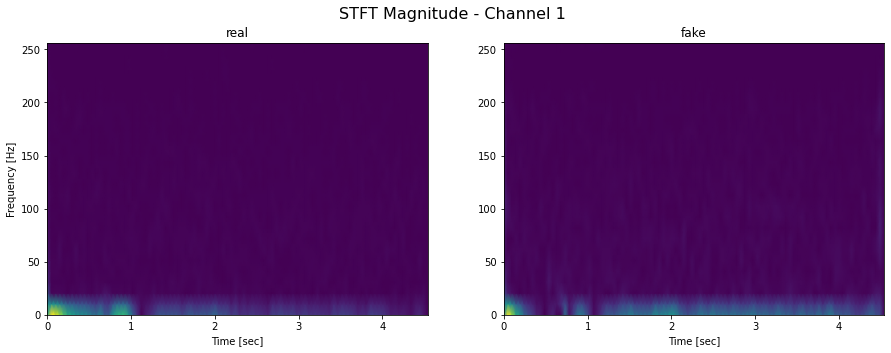

In [8]:


fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 5))

axs[0].pcolormesh(t_real, f_real, np.abs(Zxx_real), shading='gouraud')
axs[1].pcolormesh(t_fake, f_fake, np.abs(Zxx_fake), shading='gouraud')

fig.suptitle(f'STFT Magnitude - Channel {ch}', fontsize=16)

axs[0].set_title('real')
axs[1].set_title('fake')

axs[0].set_ylabel('Frequency [Hz]')

axs[0].set_xlabel('Time [sec]')
axs[1].set_xlabel('Time [sec]')

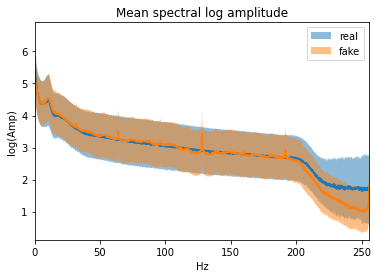

In [31]:
spectral_plot(res_X_real, X_fake, 512,  l1='real', l2='fake' )

(512, 21, 2304) (512, 21, 2304)


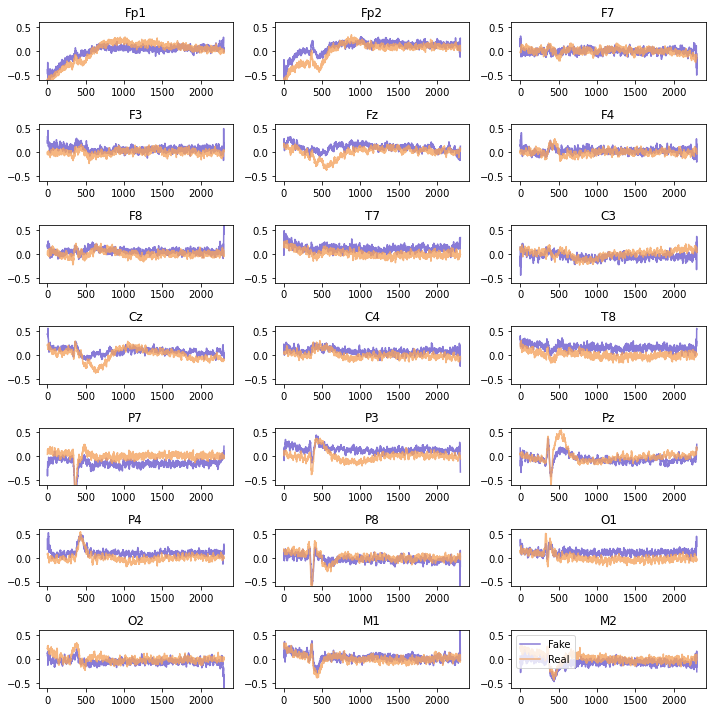

In [30]:
fig, axs = plt.subplots(ncols=3,nrows=7, figsize = (10,10))
channels = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T7', 'C3', 'Cz', 'C4', 'T8', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'O2', 'M1', 'M2']

res_X_real = downsample(X_real, 2 ** (6 - stage ), axis = 2)

for i, ax in enumerate(axs.flatten()):
    ax.plot(X_fake[:,i,:].mean(axis=0), color = 'slateblue', alpha=0.8, label='Fake')
    ax.plot(res_X_real[:,i,:].mean(axis=0), color = 'sandybrown', alpha=0.8, label='Real')
    ax.set_title(channels[i])
    ax.set_ylim(-0.6, 0.6)
plt.tight_layout()
plt.legend()

print(X_real.shape, res_X_real.shape)

In [33]:
from eeggan.examples.high_gamma.high_gamma_softplus.make_data_rest_right import CHANNELS, INPUT_LENGTH

FS = 512.

SEGMENT_IVAL = (-0.5, 4.00)
INPUT_LENGTH = int((SEGMENT_IVAL[1] - SEGMENT_IVAL[0]) * FS)
N_CHANNELS = len(CHANNELS)
CH_TYPES = ['eeg'] * N_CHANNELS

info = mne.create_info(CHANNELS, ch_types=CH_TYPES, sfreq=FS)
info.set_montage('standard_1020')

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, T7, C3, Cz, C4, T8, P7, P3, Pz, ...
 chs: 21 EEG
 custom_ref_applied: False
 dig: 24 items (3 Cardinal, 21 EEG)
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 21
 projs: []
 sfreq: 512.0 Hz
>

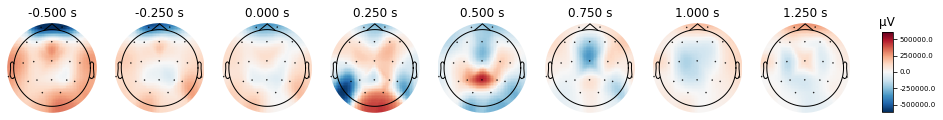

In [34]:
info['description'] = 'real'
evoked_real = mne.EvokedArray(res_X_real.mean(axis=0), info, tmin=-0.5,
                               nave=DataSet.train_data.X.shape[0], comment='real')


info['description'] = 'fake'
evoked_fake = mne.EvokedArray(X_fake.mean(axis=0), info, tmin=-0.5,
                               nave=X_fake.shape[0], comment='fake')


times = np.arange(-.5, 1.5, 0.25)

evoked_real.plot_topomap(times, average=0.1, show_names=False, ch_type='eeg', time_unit='s', image_interp='nearest', contours=0);

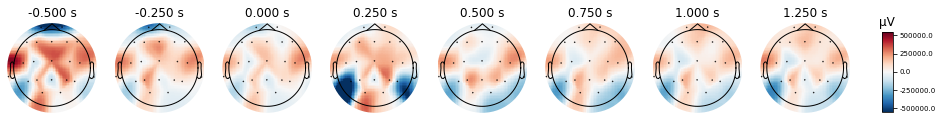

In [35]:
evoked_fake.plot_topomap(times, average=0.1, ch_type='eeg', time_unit='s', image_interp='nearest', contours=0);

### Plot Metrics

In [17]:
import pandas as pd

def metrics_to_df(stages: int, path: str):
    dataframes = []
    for i in range(stages):
        metrics = torch.load(os.path.join(path, f'metrics_stage_{i}.pt'))

        df = pd.DataFrame(metrics)

        # extract epochs
        epoch = list(list(zip(*df['wasserstein']))[0])

        # Unzip tuples and remove epoch information
        for column in df.columns:
            df[column] = list(zip(*df[column]))[1]

        # Add extra epoch column
        df['epoch'] = epoch

        # Unzip mean and std from inception score
        df['inception sdt'] = list(zip(*df['inception']))[1]
        df['inception'] = list(zip(*df['inception']))[0]

        # Unzip mean and std from classification (discard std)
        df['classification'] = list(zip(*df['classification']))[0]

        # Unpack the loss dict and concat it to the dataframe
        loss_df = pd.json_normalize(df['loss'])
        df = df.drop('loss', axis=1)

        df = pd.concat([df, loss_df], axis=1)

        dataframes.append(df)

    df = pd.concat(dataframes)
    return df


In [33]:
cGAN_path = f'/home/boehms/eeg-gan/EEG-GAN/Data/Results/ZCA_prewhitened/cGAN/1-14/'

pgGAN_path = f'/home/boehms/eeg-gan/EEG-GAN/Data/Results/ZCA_prewhitened/full_set_1_2/1-14/'

cGAN_df = metrics_to_df(5, cGAN_path)
pgGAN_df = metrics_to_df(5, pgGAN_path)


import joblib

deep4_dict = joblib.load('/home/boehms/eeg-gan/EEG-GAN/Data/Models/ZCA_prewhitened/1-14_stage4_0deep4_log.dict')

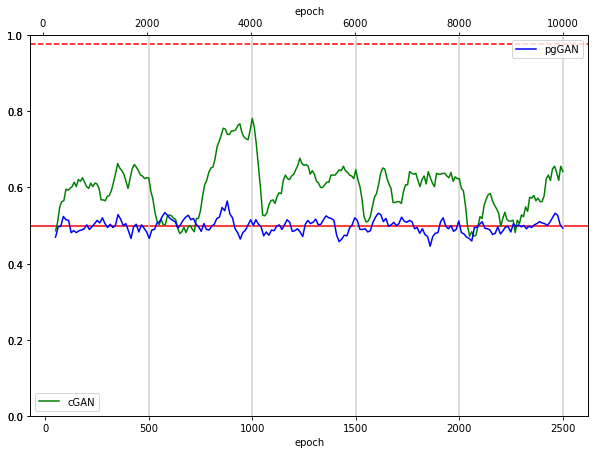

In [41]:
fig = plt.gcf()
fig.set_size_inches(10, 7)

ax = plt.gca()

plt.axhline(y=0.5, color='r', linestyle='-')
plt.axhline(y=deep4_dict['training_acc'][-1]/100, color='r', linestyle='--')

ax.vlines(x=[500,1000,1500,2000,2500], ymin=1.1, ymax=-.1, color='lightgrey')


ax2 = ax.twiny()

cGAN_df['classification_rm'] = cGAN_df['classification'].rolling(5).mean()
pgGAN_df['classification_rm'] = pgGAN_df['classification'].rolling(5).mean()



cGAN_df.plot(kind='line', x='epoch', y='classification_rm', ax=ax, color='g', label='cGAN')
pgGAN_df.plot(kind='line', x='epoch', y='classification_rm', ax=ax2, color='b', label='pgGAN')


ax.set_ylim(0,1)


plt.show()

### Prewhitening pipelines

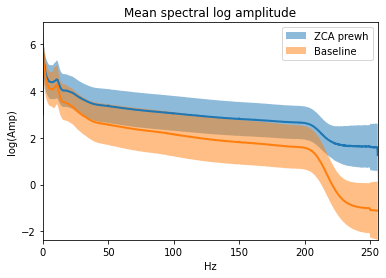

In [9]:
# ZCA prewhitening
DataSet = load_dataset(list(range(1,15)), '/home/boehms/eeg-gan/EEG-GAN/Data/Data/Baseline/')

X = DataSet.train_data.X

X_ = ZCA_whitening(DataSet.train_data.X)

spectral_plot(X_, X, 512, l1='ZCA prewh', l2='Baseline')


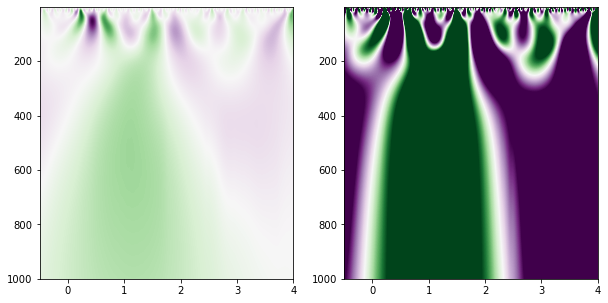

In [83]:
# Z0 prewhitening implementation
# ToDO change to pywavlet
from scipy import signal
from scipy.stats import iqr

X = np.mean(X[:,0,:], axis=0)

t = np.linspace(-.5, 4, X.shape[-1], endpoint=False)
widths = np.arange(1, 1000)


def wavelet(points, a):
    A = 2 / (np.sqrt(3 * a) * (np.pi**0.25))
    wsq = a**2
    vec = np.arange(0, points) - (points - 1.0) / 2
    xsq = vec**2
    mod = (1 - xsq / wsq)
    gauss = np.exp(-xsq / (2 * wsq))
    total = A * mod * gauss
    return (1/np.sqrt(a)) * total

cwtmatr = signal.cwt(X, wavelet, widths)

cwtmatr_ = np.zeros_like(cwtmatr)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10,5))

for i in range(len(widths)):
    mu = np.mean(cwtmatr[i])
    std = np.std(cwtmatr[i])
    Q1 = np.percentile(cwtmatr[i], 25)
    Q3 = np.percentile(cwtmatr[i], 75)
    IQR = iqr(cwtmatr[i])
    cwtmatr_[i] = (cwtmatr[i] - mu) / std

axs[0].imshow(cwtmatr, extent=[-.5, 4, 1000, 1], cmap='PRGn', aspect='auto', vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
axs[1].imshow(cwtmatr_, extent=[-.5, 4, 1000, 1], cmap='PRGn', aspect='auto', vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.show()

In [ ]:
import pywt

DataSet = load_dataset(1, '/home/boehms/eeg-gan/EEG-GAN/Data/Data/Baseline/')

X = DataSet.train_data.X

X = np.mean(X[:,0,:], axis=0)

cA, cD = pywt.dwt(X, 'gaus1')

#pywt.wavelist('gaus')

### Plot topology

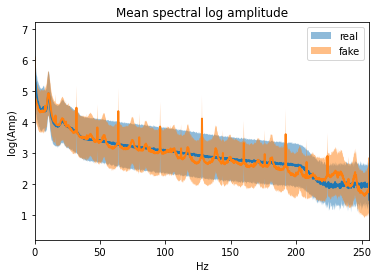

In [36]:
spectral_plot(DataSet.train_data.X, X_fake, 512, l1='real', l2='fake')

combining channels using "gfp"
combining channels using "gfp"


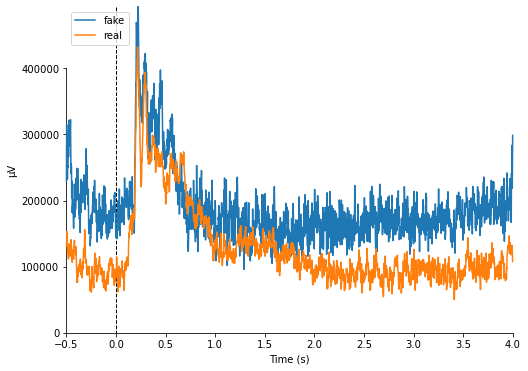

[<Figure size 576x432 with 1 Axes>]

In [92]:
 mne.viz.plot_compare_evokeds(dict(fake=evoked_fake, real=evoked_real))

No projector specified for this dataset. Please consider the method self.add_proj.


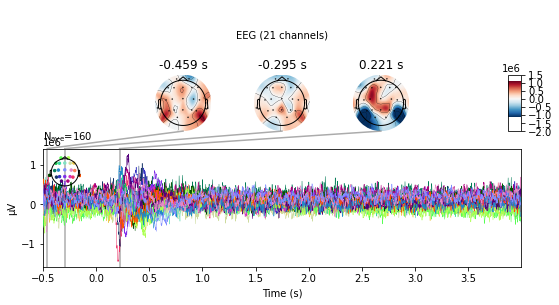

In [94]:
evoked_fake.plot_joint();

No projector specified for this dataset. Please consider the method self.add_proj.


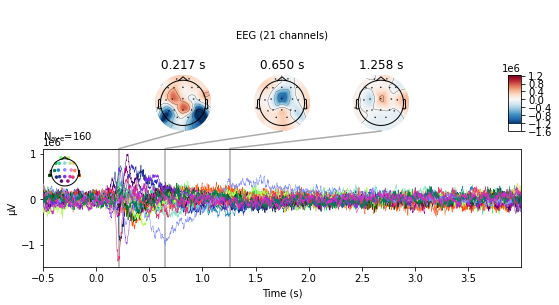

In [95]:
evoked_real.plot_joint();

### Deep4 on results

In [48]:
from dataclasses import dataclass


class Data():
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.y_onehot = self.create_onehot_vector()
    
    def __iter__(self):
        for i in range(len(self.X)):
            yield self[i]

    def __getitem__(self, index: int):
        return self.X[index], self.y[index], self.y_onehot[index],

    def __len__(self) -> int:
        return len(self.X)
    
    def create_onehot_vector(self) -> np.ndarray:
        targets_onehot = np.zeros((self.y.shape[0], 2))
        for c in range(2):
            targets_onehot[self.y == c, c] = 1

        return targets_onehot
    

In [98]:
# create dataset

# real data:
DataSet = load_dataset(1, '/home/boehms/eeg-gan/EEG-GAN/Data/Data/ZCA_prewhitened/')

X_real = DataSet.train_data.X[:]
X_real = torch.from_numpy(X_real)

y_onehot_real = torch.from_numpy(DataSet.train_data.y_onehot[:]).float()


generator, discriminator = load_GAN('/home/boehms/eeg-gan/EEG-GAN/Data/Results/ZCA_prewhitened/v1/1/', 5)

# fake data:
latent, y_fake, y_onehot_fake = to_device(X_real.device,
                                          *generator.create_latent_input(RandomState(), len(X_real)))

latent, y_fake, y_onehot_fake = detach_all(latent, y_fake, y_onehot_fake)

X_fake = generator(latent, y=y_fake, y_onehot=y_onehot_fake)

X_fake = X_fake.detach().numpy()
X_real = X_real.detach().numpy()

# create lables
y_real = np.ones(X_real.shape[0], dtype=int)
y_fake = np.zeros(X_fake.shape[0], dtype=int)

# concat fake and real + shuffle the arrays
X = np.concatenate((X_real, X_fake), axis=0)
y = np.concatenate((y_real, y_fake), axis=0)

p = np.random.permutation(len(X))
X = X[p]
y = y[p]

data = Data(X, y)



In [186]:
from braindecode.models.deep4 import Deep4Net
from torch.optim import AdamW
from torch.nn import NLLLoss
from torch.utils.data import DataLoader
from braindecode.models import ShallowFBCSPNet

# setup deep4
model = ShallowFBCSPNet(in_chans=21,
                 n_classes=2,
                 input_window_samples=X_real.shape[2],
                 final_conv_length='auto')

optimizer = AdamW(model.parameters(), lr=1 * 0.001, weight_decay=0.5 * 0.001)

loss = NLLLoss()

dataloader = DataLoader(data, batch_size=32, shuffle=True)

In [187]:
from eeggan.validation.deep4 import train_model
# train model

n_epochs = 10
trained_model, log_dict  = train_model(model=model, train_dataloader=dataloader,
                          loss=loss, optimizer=optimizer, n_epochs=n_epochs, cuda=True)

Epoch 1 - mean training loss: 0.411 - Acc %: 79.06
Epoch 10 - mean training loss: 0.000 - Acc %: 97.84


In [3]:
DataSet = load_dataset(1, '/home/boehms/eeg-gan/EEG-GAN/Data/Data/ZCA_prewhitened/')

X_real = DataSet.test_data.X[:]
X_real = torch.from_numpy(X_real)

latent, y_fake, y_onehot_fake = to_device(X_real.device,
                                          *generator.create_latent_input(RandomState(), len(X_real)))

latent, y_fake, y_onehot_fake = detach_all(latent, y_fake, y_onehot_fake)

X_fake = generator(latent, y=y_fake, y_onehot=y_onehot_fake)

y_fake = np.zeros(X_fake.shape[0], dtype=int)

out = trained_model.forward(X_real.cuda())

TypeError: object of type 'int' has no len()

In [184]:
_, predicted = torch.max(out.data, 1)

In [185]:
predicted

tensor([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
        0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1,
        1, 1, 1, 0, 0, 1, 1, 1], device='cuda:0')

In [155]:
predicted.sum().item() / len(predicted)

0.1375

In [173]:
from sklearn.metrics import confusion_matrix
from braindecode.visualization import plot_confusion_matrix

# generate confusion matrices
# get the targets
y_true = data.y
X_ =  torch.tensor(data.X).cuda()
y_pred = trained_model.forward(X_)
_, y_pred = torch.max(y_pred.data, 1)

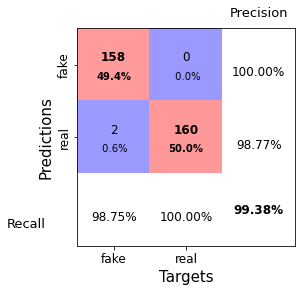

In [174]:
# generating confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred.cpu())

# add class labels
# label_dict is class_name : str -> i_class : int
labels = { 'fake':0, 'real':1}
# sort the labels by values (values are integer class labels)

# plot the basic conf. matrix
plot_confusion_matrix(confusion_mat, class_names=labels);

In [188]:
# Load and create Test set:
X_real_test = DataSet.test_data.X[:]
X_real_test = torch.from_numpy(X_real_test)

y_onehot_real = torch.from_numpy(DataSet.test_data.y_onehot[:]).float()

latent, y_fake, y_onehot_fake = to_device(X_real_test.device,
                                          *generator.create_latent_input(RandomState(), len(X_real)))

latent, y_fake, y_onehot_fake = detach_all(latent, y_fake, y_onehot_fake)

X_fake_test = generator(latent, y=y_fake, y_onehot=y_onehot_fake)

X_fake_test = X_fake_test.detach().numpy()
X_real_test = X_real_test.detach().numpy()

# create lables
y_real_test = np.ones(X_real_test.shape[0], dtype=int)
y_fake_test = np.zeros(X_fake_test.shape[0], dtype=int)

# concat fake and real + shuffle the arrays
X_test = np.concatenate((X_real_test, X_fake_test), axis=0)
y_test = np.concatenate((y_real_test, y_fake_test), axis=0)

p = np.random.permutation(len(X_test))
X_test = X_test[p]
y_test = y_test[p]

test_data = Data(X_test, y_test)

In [196]:
y_pred = trained_model.forward(torch.tensor(test_data.X).cuda())
y_true = test_data.y

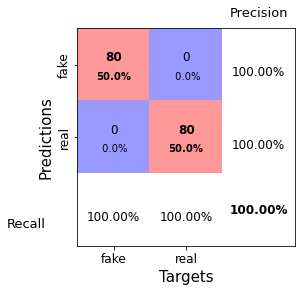

In [202]:
_, y_pred = torch.max(y_pred.data, 1)
# generating confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred.cpu().detach().numpy())

# add class labels
# label_dict is class_name : str -> i_class : int
labels = { 'fake':0, 'real':1}
# sort the labels by values (values are integer class labels)

# plot the basic conf. matrix
plot_confusion_matrix(confusion_mat, class_names=labels);

### Calculate Metrics for Network

In [36]:
class BatchOutput:
    def __init__(self, batch_real: Data[torch.Tensor], batch_fake: Data[torch.Tensor], i_epoch: int = 0):
        self.i_epoch = i_epoch
        self.batch_real = batch_real
        self.batch_fake = batch_fake


stage = 6
n_samples = 512
subj_ind = list(range(1,15))

# Load real Dataset:
DataSet = load_dataset(subj_ind, '/home/boehms/eeg-gan/EEG-GAN/Data/Data/ZCA_prewhitened/')


# Draw n_samples random samples from the real data set
random_sample = np.random.randint(0, DataSet.train_data.X.shape[0], n_samples)
batch_real = DataSet.train_data.subset(random_sample)

random_sample = np.random.randint(0, DataSet.train_data.X.shape[0], n_samples)
batch_real1 = DataSet.train_data.subset(random_sample)



# Generate fake X Batch
batch_fake = create_fake_data('/home/boehms/eeg-gan/EEG-GAN/Data/Results/ZCA_prewhitened/full_set_1_2/1-14/', stage, n_samples)


In [5]:
batch_real.X = Tensor(batch_real.X)
batch_fake.X = Tensor(batch_fake.X)
batch_real1.X = Tensor(batch_real1.X)

batch = BatchOutput(batch_real, batch_real1)

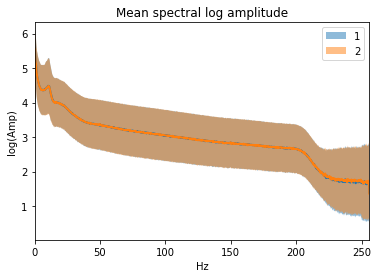

In [9]:
spectral_plot(batch.batch_real.X, batch.batch_fake.X, 512, l1='1', l2='2')

In [3]:
from eeggan.examples.high_gamma.braindecode_hack import IntermediateOutputWrapper
from eeggan.training.handlers.metrics import WassersteinMetric, WassersteinMetricPOT, InceptionMetric, LossMetric, ClassificationMetric
from torch import Tensor
import pandas as pd

def calculate_metrics(GAN_path, DataSet, stage, data_path, subj_ind, batchsize, deep4_path):
    
    # Draw n_samples random samples from the real data set
    random_sample = np.random.randint(0, DataSet.train_data.X.shape[0], batchsize)
    batch_real1 = DataSet.train_data.subset(random_sample)
    
    random_sample = np.random.randint(0, DataSet.train_data.X.shape[0], batchsize)
    batch_real2 = DataSet.train_data.subset(random_sample)
    
    # scale data for current stage
    sample_factor = 2 ** (6 - stage)
    batch_real1.X = downsample(batch_real1.X, factor=sample_factor, axis=2)
    batch_real2.X = downsample(batch_real2.X, factor=sample_factor, axis=2)

    
    # Generate fake X Batch
    batch_fake = create_fake_data(GAN_path, stage, batchsize) 
    

    realVSreal = BatchOutput(batch_real1, batch_real2)
    realVSfake = BatchOutput(batch_real1, batch_fake)
    
    batches = [realVSreal, realVSfake]
    batch_names = ['real vs real', 'real vs fake']
    
    # load trained deep4s for stage
    deep4s = load_deeps4(subj_ind, stage-1, deep4_path)
    select_modules = ['pool_4', 'softmax']
    deep4s = [to_cuda(IntermediateOutputWrapper(select_modules, deep4)) for deep4 in deep4s]

    
    # initiate metrics
    metric_wasserstein = WassersteinMetric(100, np.prod(batch_real1.X.shape[1:]).item(), tb_writer=None)
    metric_inception = InceptionMetric(deep4s, sample_factor, tb_writer=None)

    
    metrics = [metric_wasserstein, metric_inception]
    metric_names = ['SWD', 'IS']
    
    df = pd.DataFrame()
    
    for i, batch in enumerate(batches):
        batch.batch_real.X = Tensor(batch.batch_real.X)
        batch.batch_fake.X = Tensor(batch.batch_fake.X)
        batch.i_epoch = batch_names[i]
        for metric in metrics:
            metric.update(batch)
    
    for i, metric in enumerate(metrics):
        df[metric_names[i]] = list(zip(*metric.values))[1]
        
    df.index = batch_names
    
    return df
    
    


In [4]:
GAN_path = '/home/boehms/eeg-gan/EEG-GAN/Data/Results/ZCA_prewhitened/3342_samples/1-14/'
stage = 6
data_path = '/home/boehms/eeg-gan/EEG-GAN/Data/Data/ZCA_prewhitened'
subj_ind = list(range(1,15))
batchsize = 256
deep4_path = '/home/boehms/eeg-gan/EEG-GAN/Data/Models/ZCA_prewhitened'

DataSet = load_dataset(subj_ind, data_path)

In [5]:
results = []

GAN_Paths = [    
    '/home/boehms/eeg-gan/EEG-GAN/Data/Results/ZCA_prewhitened/full_set_1_2/1-14/',
    
    '/home/boehms/eeg-gan/EEG-GAN/Data/Results/ZCA_prewhitened/880_samples/1-14/',
    '/home/boehms/eeg-gan/EEG-GAN/Data/Results/ZCA_prewhitened/1360_samples/1-14/',
    '/home/boehms/eeg-gan/EEG-GAN/Data/Results/ZCA_prewhitened/3342_samples/1-14/',

    
    '/home/boehms/eeg-gan/EEG-GAN/Data/Results/ZCA_prewhitened/2_subjects/14,7/',
    '/home/boehms/eeg-gan/EEG-GAN/Data/Results/ZCA_prewhitened/4_subjects/1,5,7,13/',
    '/home/boehms/eeg-gan/EEG-GAN/Data/Results/ZCA_prewhitened/8_subjects/14,13,2,8,6,4,12,3/',

]

for path in GAN_Paths:
    results.append(calculate_metrics(path, DataSet, stage, data_path, subj_ind, batchsize, deep4_path))

/home/boehms/eeg-gan/EEG-GAN/EEG-GAN/eeggan/validation/metrics/inception.py:25: RuntimeWarning: Mean of empty slice
  return np.nanmean(scores).item(), np.nanstd(scores).item()
/home/boehms/miniconda3/envs/EEG-GAN/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/boehms/eeg-gan/EEG-GAN/EEG-GAN/eeggan/training/handlers/metrics.py:142: RuntimeWarning: Mean of empty slice
  self.append((epoch, (np.nanmean(score_means).item(), np.nanmean(score_stds).item())))
/home/boehms/eeg-gan/EEG-GAN/EEG-GAN/eeggan/validation/metrics/inception.py:25: RuntimeWarning: Mean of empty slice
  return np.nanmean(scores).item(), np.nanstd(scores).item()
/home/boehms/miniconda3/envs/EEG-GAN/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/boehms/eeg-gan/EEG

In [8]:
df = pd.concat(results)

In [16]:
# results.plot(kind='bar', y='SWD')
rr = df.iloc[::2]
rf = df.iloc[1::2]

In [18]:
names = ['full set', '880', '1360', '3342', '2 subj', '4 subj', '8 subj']

rr.index = names
rf.index = names
    

<AxesSubplot:title={'center':'SWD real vs real'}>

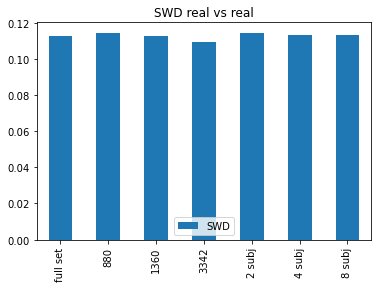

In [25]:
rr.plot(kind='bar', y='SWD', title= 'SWD real vs real')

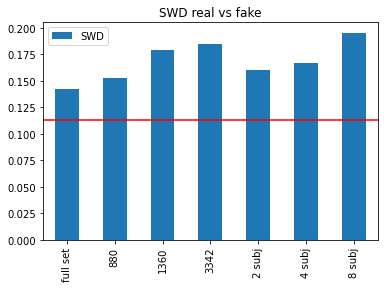

In [31]:
ax = plt.gca()

rf.plot(kind='bar', y='SWD', title= 'SWD real vs fake', ax=ax);
ax.axhline(y = rr['SWD'].mean(), color='red')

In [28]:
rr['SWD'].mean()

0.11277926683874122

In [ ]:
DataSet = load_dataset(list(range(1,15)), '/home/boehms/eeg-gan/EEG-GAN/Data/Data/ZCA_prewhitened/')

In [5]:
DataSet.train_data.X.shape

(5622, 21, 2304)

In [7]:
DataSet.train_data.X = np.concatenate((DataSet.train_data.X[:], DataSet.test_data.X[:]), axis=0)
DataSet.train_data.y = np.concatenate((DataSet.train_data.y[:], DataSet.test_data.y[:]), axis=0)
DataSet.train_data.y_onehot = np.concatenate((DataSet.train_data.y_onehot[:], DataSet.test_data.y_onehot[:]), axis=0)


In [8]:
DataSet.train_data.X.shape

(6742, 21, 2304)

In [10]:
index = np.random.randint(low=0, high=DataSet.train_data.X.shape[0], size = 250)

DataSet.train_data.X = DataSet.train_data.X[index]
DataSet.train_data.y = DataSet.train_data.y[index]
DataSet.train_data.y_onehot = DataSet.train_data.y_onehot[index]

In [11]:
DataSet.train_data.X.shape

(250, 21, 2304)

### Compare real and fake

In [4]:
real = load_dataset(list(range(1,15)), '/home/boehms/eeg-gan/EEG-GAN/Data/Data/ZCA_prewhitened/')
real.train_data.X = np.concatenate((real.train_data.X[:], real.test_data.X[:]), axis=0)
real.train_data.y = np.concatenate((real.train_data.y[:], real.test_data.y[:]), axis=0)
real.train_data.y_onehot = np.concatenate((real.train_data.y_onehot[:], real.test_data.y_onehot[:]), axis=0)

In [ ]:
fake = create_fake_data('/home/boehms/eeg-gan/EEG-GAN/Data/Results/ZCA_prewhitened/full_set_1_2/1-14/', 6, real.train_data.X.shape[0])

In [4]:
CHANNELS = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T7', 'C3', 'Cz', 'C4', 'T8', 'P7', 'P3', 'Pz', 'P4',
            'P8', 'O1', 'O2', 'M1', 'M2']

In [6]:
rest = real.train_data.X[real.train_data.y == 1]
right = real.train_data.X[real.train_data.y == 0]

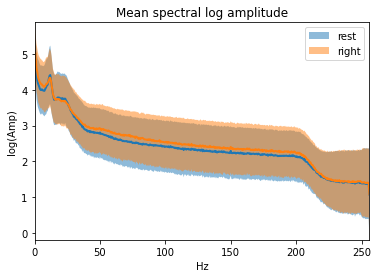

In [42]:
spectral_plot(rest[:, [8], :512*2], right[:, [8], :512*2], 512, l1 = 'rest', l2 = 'right' )

In [40]:
rest.shape

(3370, 21, 2304)

In [20]:
rest_mean = np.mean(rest[:, [8,13]], axis=0)
right_mean = np.mean(right[:, [8,13]], axis=0)


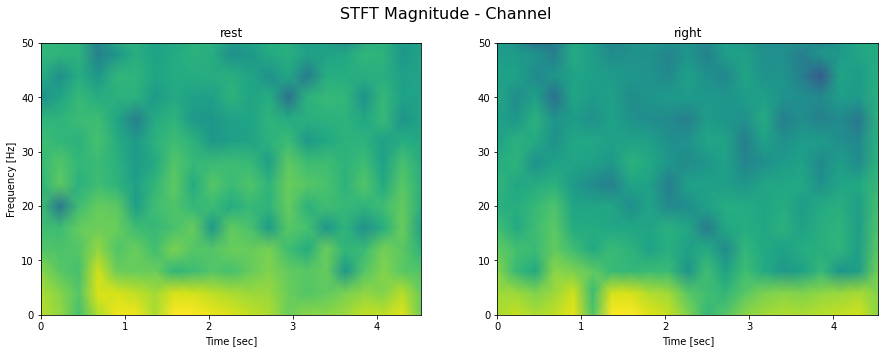

In [39]:
# 1. defining window length (resolution should be around 2Hz) 
# 2. window_step = 0.1 * window_length 
# 3. compute time freq. data

window_size = 128

f_rest, t_rest, Zxx_rest = signal.stft(rest_mean[0], 512, nperseg=window_size, noverlap=0.1*window_size)
f_right, t_right, Zxx_right = signal.stft(right_mean[0], 512, nperseg=window_size, noverlap=0.1*window_size)

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 5))

axs[0].pcolormesh(t_rest, f_rest, np.log(np.abs(Zxx_rest)), shading='gouraud')
axs[1].pcolormesh(t_right, f_right, np.log(np.abs(Zxx_right)), shading='gouraud')

fig.suptitle(f'STFT Magnitude - Channel', fontsize=16)

axs[0].set_title('rest')
axs[1].set_title('right')

axs[0].set_ylabel('Frequency [Hz]')

axs[0].set_xlabel('Time [sec]')
axs[1].set_xlabel('Time [sec]')

for ax in axs:
    ax.set_ylim(0,50)
    

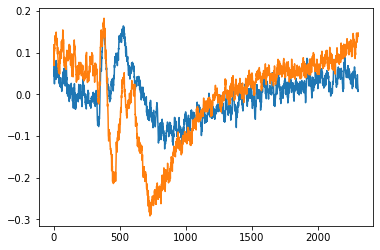

In [22]:
plt.plot(rest_mean[0])
plt.plot(right_mean[0])

In [44]:
from eeggan.examples.high_gamma.high_gamma_softplus.make_data_rest_right import CHANNELS, INPUT_LENGTH

FS = 512.

SEGMENT_IVAL = (-0.5, 4.00)
INPUT_LENGTH = int((SEGMENT_IVAL[1] - SEGMENT_IVAL[0]) * FS)
N_CHANNELS = len(CHANNELS)
CH_TYPES = ['eeg'] * N_CHANNELS

info = mne.create_info(CHANNELS, ch_types=CH_TYPES, sfreq=FS)
info.set_montage('standard_1020')

info['description'] = 'rest'
evoked_real = mne.EvokedArray(real.train_data.X.mean(axis=0), info, tmin=-0.5,
                               nave=real.train_data.X.shape[0], comment='real')

In [46]:
evk_spectrum = evoked_real.compute_psd()

AttributeError: 'EvokedArray' object has no attribute 'compute_psd'

In [ ]:
mne.EpochsArray(real.train_data.X, info=info, events=real.train_data.y, tmin=-0.5)

In [ ]:
events = np.column_stack((real.train_data.X,
                          real.train_data.y))
event_dict = dict(condition_A=1, condition_B=2)
simulated_epochs = mne.EpochsArray(data, info, tmin=-0.5, events=events,
                                   event_id=event_dict)

In [ ]:
events  = np.column_stack((np.arange(0, real.train_data.y.shape[0]*512, 512), np.zeros(real.train_data.y.shape[0], dtype=int), real.train_data.y))

### FFT
you input epoch data to computeStft<br> 
then its output into computeMedian<br>
its output into plotStft and generate the plots

In [40]:
def computeStft(epochs_left, fs, wsize):

# choose the overlap size as needed
    noverlap = wsize * .1
    temp_stft_arr = []
    for row in epochs_left:
        f, t, Zxx = signal.stft(
            row,
            fs,
            nperseg=wsize,
            noverlap=noverlap,
            padded=False,
            boundary=None,
            window="hann",
        )
        temp_stft_arr.append(Zxx)

    stft_arr = np.asarray(np.abs(temp_stft_arr) ** 2)
    del temp_stft_arr
    return stft_arr, f, t


# generate the plot
def plotStft(stft_power, t, f, new_title, cbar_label):
    fig, ax = plt.subplots()
    pcm = ax.pcolormesh(
        t - .5,
        f,
        stft_power,
        cmap="RdBu_r",
    )
    
    plt.grid(False)

    figure = plt.gcf()  # get current figure
    figure.set_size_inches(10, 5)  
    # set figure's size manually to your full screen (32x18)
    # figure.colorbar(pcm, location="right")
    figure.subplots_adjust(right=0.87)
    cbar_ax = figure.add_axes([0.87, 0.05, 0.04, 0.5])
    cbar = figure.colorbar(pcm, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(cbar_label, rotation=-270, fontsize=16, labelpad=30)
    ax.set_ylim(0,50)
    plt.show()
    
# # compute the median
def computeMedian(stft_arr):
    avg = np.median(stft_arr, axis=0)
    # take the mean of the median
    # stft_arr2 = data
    avg_mean = np.mean(avg, axis=-1)

    # rescale by mean
    avg_reshaped = np.expand_dims(avg_mean, axis=-1)
    print(avg_reshaped.shape)
    avg_reshaped = np.broadcast_to(
        avg_reshaped,
        (
            avg_mean.shape[0],
            avg_mean.shape[1],
            avg_mean.shape[2],
            stft_arr.shape[-1],
        ),
    )

    # expand to trials
    avg_reshaped = np.broadcast_to(
        avg_reshaped,
        (
            stft_arr.shape[0],
            avg_reshaped.shape[0],
            avg_reshaped.shape[1],
            avg_reshaped.shape[2],
            # avg_reshaped.shape[3],
        ),
    )

    stft_arr_temp = np.divide(stft_arr, avg_reshaped)
    del avg_reshaped, stft_arr, avg_mean
    # # take the median of bl corrected epochs
    stft_med = np.median(stft_arr_temp, axis=0)
    # stft_med = np.mean(stft_arr3, axis=0)
    med_log = 10 * np.log10(stft_med)
    del stft_arr_temp, stft_med
    return med_log

In [41]:
fs = 512.
wsize = 100
rest_fft, f, t = computeStft(rest[:,8, :], fs, wsize)
right_fft, f, t = computeStft(right[:,8, :], fs, wsize)

    

In [42]:
rest_mean = np.mean(rest_fft, axis = 0)
right_mean = np.mean(right_fft, axis = 0)

# plot the STFT
# plotStft(med_log, t, f, 'test', 'cbar')

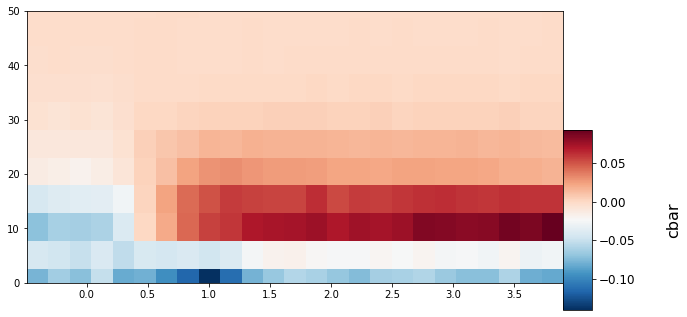

In [43]:
plotStft(rest_mean - right_mean, t, f, 'test', 'cbar')

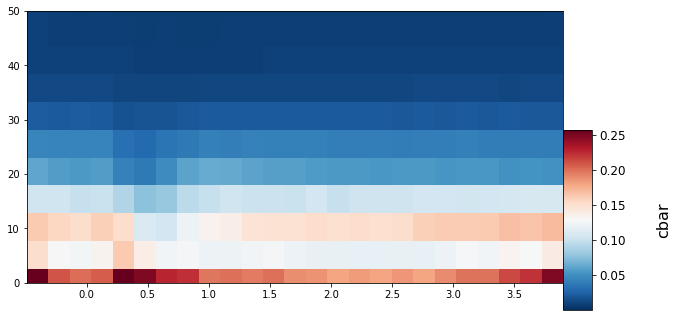

In [44]:
plotStft(rest_mean, t, f, 'test', 'cbar')

In [53]:
fake = create_fake_data('/home/boehms/eeg-gan/EEG-GAN/Data/Results/ZCA_prewhitened/cGAN/1-14/', 6, 500)

In [54]:
f_rest = fake.X[fake.y == 1].detach().numpy()
f_right = fake.X[fake.y == 0].detach().numpy()

In [55]:
fs = 512.
wsize = 100
rest_fft, f, t = computeStft(f_rest[:,8, :], fs, wsize)
right_fft, f, t = computeStft(f_right[:,8, :], fs, wsize)

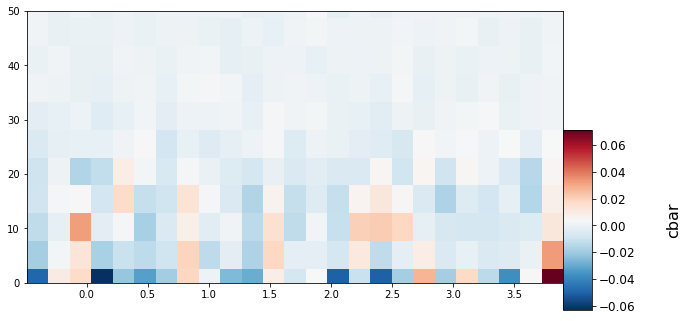

In [52]:
rest_mean = np.mean(rest_fft, axis = 0)
right_mean = np.mean(right_fft, axis = 0)
plotStft(rest_mean - right_mean, t, f, 'test', 'cbar')

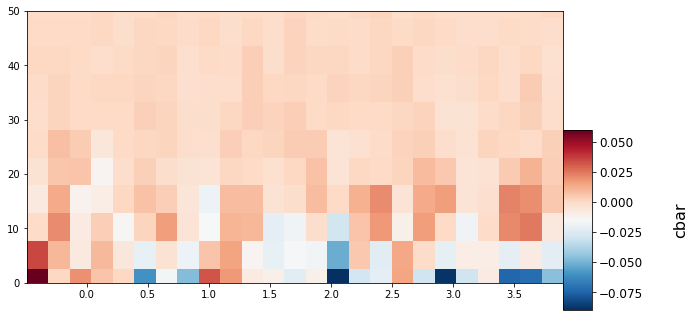

In [58]:
rest_mean = np.mean(rest_fft, axis = 0)
right_mean = np.mean(right_fft, axis = 0)
plotStft(rest_mean - right_mean, t, f, 'test', 'cbar')